In [1]:
import numpy as np
import tensorflow as tf
import os, glob
import matplotlib.pyplot as plt
from PIL import Image
from celluloid import Camera
from IPython.display import HTML
import collections.abc
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [5]:
os.chdir("..")
basedir = os.getcwd()
basedir

'/home/aadam/Desktop/Projects/ExoRIM'

In [6]:
id = "20-06-07_22-42-35"
results_dir = os.path.join(basedir, "results", id)
checkpoints_dir = os.path.join(basedir, "models", id)
train_data_dir = os.path.join(basedir, "data", id + "_train")
test_data_dir = os.path.join(basedir, "data", id + "_test")

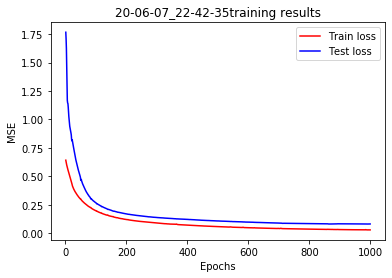

In [7]:
train_loss = np.loadtxt(os.path.join(results_dir, "train_loss.txt"))
test_loss = np.loadtxt(os.path.join(results_dir, "test_loss.txt"))
epochs = [i for i in range(1, train_loss.size + 1)]
plt.figure()
plt.plot(epochs, train_loss, "-r", label="Train loss")
plt.plot(epochs, test_loss, "-b", label="Test loss")
plt.title(id + "training results")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.savefig(os.path.join(results_dir, "learning_curve.png"))

In [8]:
test_loss.min()

0.08159734308719635

In [9]:
# update of nested dictionaries
def update(d, u):
    for k, v in u.items():
        if isinstance(v, collections.abc.Mapping):
            d[k] = update(d.get(k, {}), v)
        else:
            d[k] = v
    return d

images = {}
for file in glob.glob(os.path.join(results_dir, "output*")):
    name = os.path.split(file)[-1]
    epoch = int(name[7:10])
    index = int(name[11:15])
    step = int(name[16:18])
    with Image.open(file) as image:
        im = np.array(image.getdata()).reshape([image.size[0], image.size[1]])
        update(images, {index: {epoch : {step: im}}})

In [10]:
ground_truth = {}
for file in glob.glob(os.path.join(train_data_dir, "image[0-9]*")):
    name = os.path.split(file)[-1]
    index = int(name[5:8])
    if index % 100 == 0:
        with Image.open(file) as image:
            im = np.array(image.getdata()).reshape(image.size[0], image.size[1])
            ground_truth[index] = im

In [19]:
%%capture

index = 400 # [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
step = 11  # [0, 3, 6, 9, 11]
fig = plt.figure()
cam = Camera(fig)
selected_image = images[index]
for key in sorted(list(selected_image.keys())):
    plt.imshow(selected_image[key][step], cmap="gray")
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, "output.mp4"), writer="ffmpeg")
anim1 = HTML(animation.to_html5_video())

In [20]:
%%capture
fig = plt.figure()
cam = Camera(fig)
for key in sorted(list(selected_image.keys())):
    plt.imshow(np.abs(selected_image[key][step] - ground_truth[index]), cmap="gray")
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, "residual.mp4"), writer="ffmpeg")
anim2 = HTML(animation.to_html5_video())

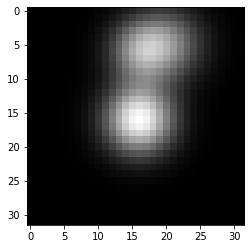

In [21]:
plt.figure()
plt.imshow(ground_truth[index], cmap="gray")
plt.savefig(os.path.join(results_dir, "ground_truth.png"))

In [22]:
# Output
anim1

In [23]:
# Residual
anim2